# Mapping CG PMFs onto the Continuum Model
In this notebook, we show how to predict the parameters of the CG model yielding a given combination of free energy maxima and minima for neutral and charged amino acids.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os, sys, json, shutil
from math import asinh, sqrt, pi
import pandas as pd
import glob
import mdtraj as md
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from mpl_toolkits.axes_grid1 import make_axes_locatable
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/giulio/miniconda3/envs/pepmem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Parametrized Expressions of Free Energy Values for Amino Acids at the Midplane and at the Interface

In [2]:
def min0(aa,ah,at,x):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*aa*x**3*Rl**3/2.
    s=.0175*ah
    I1= 1.15*3*(b+s)/b**4 - 1.15*3./(b+s)**3 + 3*h/(b+s)**4
    I2= 3*(b+s-h)/(b+s)**4 + 1./(b+s)**3 - 1./(t+h)**3
    I3= 1./(t+h)**3 - 1./(t+2*h)**3
    return C*(ah*I1+at*I2+ah*I3)+0.5*2*pi*(x+s-h)*(x+s)
def max0(aa,ah,at,x):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*aa*x**3*Rl**3/2.
    I1=4./b**3 - 8./t**3 
    I2=8./t**3 - 1./(t/2.+h)**3 
    return C*(3.36*at*I1+ah*I2)+6.2*4*np.pi*(x+0.084)**2
def min1(aa,ah,at,x):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*Rl**3*.71/2.
    s=0.057*ah
    I1= 0.927*(b+s)/b/b - 0.927*1./(b+s) + h/(b+s)**2
    I2= (b+s-h)/(b+s)**2 + 1./(b+s) - 1./(t+h)
    I3= 1./(t+h) - 1./(t+2*h)
    return C*(ah*I1+at*I2+ah*I3)+0.5*2*np.pi*(x+s-h)*(x+s)
def max1(aa,ah,at,x):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*Rl**3*.71
    s=0.0093*(ah-at)
    I1= 2./(b+s) - 2./t
    I2= 2./t - 1./(t/2.+h)  
    I3= (b+s)/b/b - 1./(b+s)
    return C*(at*I1+ah*I2+2.27*ah*I3)+6.2*4*np.pi*(s+0.22)**2

In [3]:
def plotting(extr,sub,ahlg=0):
    radii = np.array([1.5,2,2.5,3])/10
    x = np.linspace(.14,.31,100)
    ahs = np.array([25,30,35]); ats = np.array([-30,-35])
    func = min0 if extr=='min0' else min1 if extr=='min1' else max0 if extr=='max0' else max1
    aas = np.array([1]) if extr[-1]=='1' else np.array([1,2])
    for aa in aas:
        mrkr = 'o' if aa==1 else '^'
        cnt = 0
        for ah in ahs:
            for at in ats:
                m = pmfs.loc[ah,at,aa][extr].values
                em = pmfs.loc[ah,at,aa]['E'+extr].values
                params = aa,ah,at
                sub.plot(x*10,func(*params,x),color=colors[cnt],lw=1)
                if ah==ahlg and mrkr=='o':
                    sub.errorbar(radii*10,m,em,lw=0,marker=mrkr,color=colors[cnt],
                        markeredgecolor=None,ms=7,elinewidth=1.,capsize=2,capthick=1.,
                        label=r'$\alpha_h$={:1g}'.format(ah)+r', $\alpha_t$={:1g}'.format(at))
                else:
                    sub.errorbar(radii*10,m,em,lw=0,marker=mrkr,color=colors[cnt],
                        markeredgecolor=None,ms=7,elinewidth=1.,capsize=2,capthick=1.)
                cnt += 1
                if cnt > 9: cnt = 0

In [4]:
if os.path.isfile('coarsegrained/pmfs.p'):
    pmfs = pd.read_pickle('coarsegrained/pmfs.p')

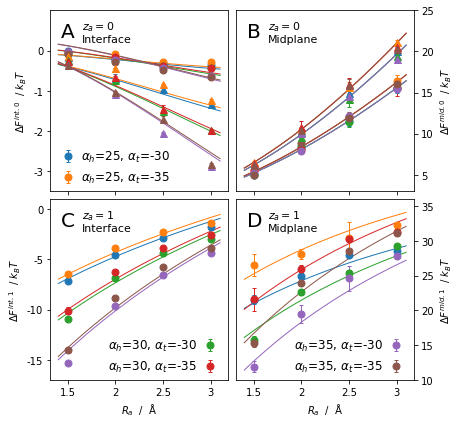

In [5]:
plt.rcParams.update({'figure.figsize': [6.5, 6]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
plotting('min0',ax1,25)
plotting('max0',ax2)
plotting('min1',ax3,30)
plotting('max1',ax4,35)
for ax in f.axes:
    ax.set_xticks(np.arange(1.5,3.5,.5))
ax3.set_xticklabels('{:1g}'.format(i) for i in np.arange(1.5,3.5,.5))
ax4.set_xticklabels('{:1g}'.format(i) for i in np.arange(1.5,3.5,.5))
ax1.set_xticklabels(np.tile([''],4))
ax2.set_xticklabels(np.tile([''],4))
ax1.set_ylim(-3.5,1); ax2.set_ylim(3,25)
ax3.set_ylim(-17,1); ax4.set_ylim(10,36)
ax1.set_yticks(np.arange(-3,.5,1)); ax2.set_yticks(np.arange(5,30,5))
ax3.set_yticks(np.arange(-15,1,5)); ax4.set_yticks(np.arange(10,40,5))
ax1.set_yticklabels('{:1g}'.format(i) for i in np.arange(-3,.5,1))
ax2.set_yticklabels('{:1g}'.format(i) for i in np.arange(5,30,5))
ax3.set_yticklabels('{:1g}'.format(i) for i in np.arange(-15,1,5))
ax4.set_yticklabels('{:1g}'.format(i) for i in np.arange(10,40,5))
ax3.set_xlabel('$R_a$  /  Å'); ax4.set_xlabel('$R_a$  /  Å')
ax1.set_ylabel('$\Delta F^{int.0}$  / $k_B T$'); ax2.set_ylabel('$\Delta F^{mid.0}$  / $k_B T$')
ax3.set_ylabel('$\Delta F^{int.1}$  / $k_B T$'); ax4.set_ylabel('$\Delta F^{mid.1}$  / $k_B T$')
ax2.yaxis.set_ticks_position('right'); ax4.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right'); ax4.yaxis.set_label_position('right')
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate('$z_a=0$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax2.annotate('$z_a=0$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax3.annotate('$z_a=1$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax4.annotate('$z_a=1$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax1.legend(numpoints=1,handletextpad=0.1,loc='lower left',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=True)
ax3.legend(numpoints=1,handletextpad=0.1,loc='lower right',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=False)
ax4.legend(numpoints=1,handletextpad=0.1,loc='lower right',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=False)
f.tight_layout(w_pad=.1,h_pad=.1)    
plt.show()

### Mapping Free Energy Values for an All-atom Arginine Monopeptide onto the Coarse-grained Model

In [6]:
if os.path.isfile('allatom/allatom.p'):
    allatom = pd.read_pickle('allatom/allatom.p')
mn0tgt,mx0tgt,mn1tgt,mx1tgt = allatom.loc['R',['min0','max0','min1','max1']]

data=[]
for R in np.arange(.2,.26,.05):
    for ah in np.arange(0,50,2):
        for at in np.arange(-50,-1,2):
            mx1 = max1(1,ah,at,R)
            mn1 = min1(1,ah,at,R)
            for aa in np.arange(2,3,.5):
                mx0 = max0(aa,ah,at,R)
                mn0 = min0(aa,ah,at,R)
                if np.abs(mx1-mx1tgt)<2 and np.abs(mx0-mx0tgt)<4 and np.abs(mn1-mn1tgt)<2 and np.abs(mn0-mn0tgt)<4:
                    data.append({'aa':round(aa,1),'ah':ah,'at':at,'R':round(R,2),
                                 'min0':mn0,
                                 'max0':mx0,
                                 'min1':mn1,
                                 'max1':mx1,
                                 'Emin0':np.abs(mn0-mn0tgt),
                                 'Emax0':np.abs(mx0-mx0tgt),
                                 'Emin1':np.abs(mn1-mn1tgt),
                                 'Emax1':np.abs(mx1-mx1tgt)})
predict = pd.DataFrame(data)
predict = predict.set_index(['aa','ah','at','R'])

### Several Combinations of Suitable Arginine Parameters Ranked in Order of Ascending Free Energy at the Midplane for the Neutral Amino Acid

In [7]:
predict['Esum'] = predict['Emax0']+predict['Emax1']+predict['Emin0']+predict['Emin1']

In [8]:
predict.sort_values('Esum',ascending=True)

Emax0     Emax1     Emin0     Emin1       max0       max1  \
aa  ah at  R                                                                    
2.5 46 -44 0.25  0.350470  0.322651  2.220198  0.326099  19.251489  30.848949   
2.0 46 -44 0.25  2.462468  0.322651  1.123813  0.326099  17.139490  30.848949   
2.5 48 -44 0.25  0.351597  0.827144  2.459415  0.646756  19.250362  29.699153   
       -46 0.25  0.129581  1.314153  2.447943  0.563105  19.731539  31.840451   
    44 -42 0.25  0.830521  0.653851  1.996797  1.187706  18.771438  29.872447   
       -44 0.25  0.349343  1.433232  1.983828  1.280889  19.252615  31.959529   
    46 -42 0.25  0.831647  1.767886  2.232389  0.237829  18.770311  28.758412   
2.0 48 -44 0.25  2.463370  0.827144  1.279011  0.646756  17.138588  29.699153   
       -46 0.25  2.078428  1.314153  1.269833  0.563105  17.523531  31.840451   
    44 -42 0.25  2.846509  0.653851  0.979728  1.187706  16.755449  29.872447   
    46 -42 0.25  2.847411  1.767886  1.133565  0.237829  16.754548  28.758412   
    44 -44 0.25  2.461567  1.433232  0.969353  1.280889  17.140391  31.959529   

                     min0       min1      Esum  
aa  ah at  R                                    
2.5 46 -44 0.25 -3.642445 -10.966883  3.219418  
2.0 46 -44 0.25 -2.546060 -10.966883  4.235032  
2.5 48 -44 0.25 -3.881662 -11.939738  4.284911  
       -46 0.25 -3.870190 -11.856087  4.454783  
    44 -42 0.25 -3.419044 -10.105276  4.668874  
       -44 0.25 -3.406075 -10.012093  5.047292  
    46 -42 0.25 -3.654636 -11.055153  5.069751  
2.0 48 -44 0.25 -2.701258 -11.939738  5.216280  
       -46 0.25 -2.692080 -11.856087  5.225519  
    44 -42 0.25 -2.401975 -10.105276  5.667794  
    46 -42 0.25 -2.555812 -11.055153  5.986691  
    44 -44 0.25 -2.391600 -10.012093  6.145041

### Several Combinations of Suitable Arginine Parameters Ranked in Order of Ascending Free Energy at the Midplane for the Neutral Amino Acid

-5.354158987978371 0.27994279926407106
3.4850702337713773 34.14031356938963
-9.113133189602125 0.015319378439785036
3.908719515745859 42.047104318020274
-25.042449250528144 2.46655992629496
1.2707750289735316 37.42721535623625


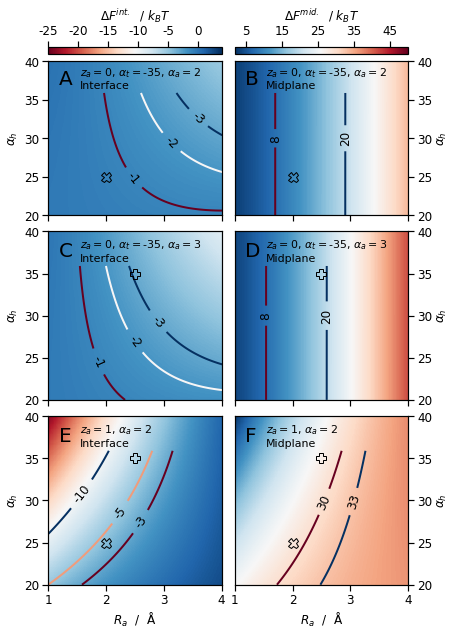

In [9]:
plt.rcParams.update({'font.size': 12,'xtick.major.pad':3,'ytick.major.pad':3,'figure.dpi':72,
                     'xtick.major.size':6,'ytick.major.size':6,'legend.fontsize':12,
                     'xtick.direction':'out','ytick.direction':'out','axes.labelsize':12,
                     'axes.linewidth':1.2,'xtick.labelsize':12,'ytick.labelsize':12,
                     'xtick.major.width':1.2, 'ytick.major.width':1.2})
plt.rcParams.update({'figure.figsize': [6.5, 9]})
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3,ncols=2)
ahs = np.arange(20,41,.1); radii = np.arange(.1,.401,.001)

vminInt=-25
vmaxInt=4
vminMid=2
vmaxMid=50

Z1 = min0(2,ahs[:,np.newaxis],-35,radii)
im1 = ax1.imshow(Z1,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminInt,vmax=vmaxInt,cmap=plt.cm.RdBu)
Z2 = max0(2,ahs[:,np.newaxis],-35,radii)
im2 = ax2.imshow(Z2,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminMid,vmax=vmaxMid,cmap=plt.cm.RdBu_r)
Z3 = min0(3,ahs[:,np.newaxis],-35,radii)
im3 = ax3.imshow(Z3,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminInt,vmax=vmaxInt,cmap=plt.cm.RdBu)
Z4= max0(3,ahs[:,np.newaxis],-35,radii)
im4 = ax4.imshow(Z4,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminMid,vmax=vmaxMid,cmap=plt.cm.RdBu_r)
Z5 = min1(2,ahs[:,np.newaxis],-35,radii)
im5 = ax5.imshow(Z5,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminInt,vmax=vmaxInt,cmap=plt.cm.RdBu)
Z6= max1(2,ahs[:,np.newaxis],-35,radii)
im6 = ax6.imshow(Z6,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminMid,vmax=vmaxMid,cmap=plt.cm.RdBu_r)

for Z in [Z1,Z2,Z3,Z4,Z5,Z6]:
    print(Z.min(),Z.max())

for ax in f.axes:
    ax.set_xlim(.1,.4)
    ax.set_xticks(np.arange(.1,.41,.1))
    ax.set_ylim(20,40)
    ax.set_yticks(np.arange(20,41,5))
    ax.set_yticklabels('{:1g}'.format(i) for i in np.arange(20,41,5))
    ax.set_ylabel(r'$\alpha_h$')

ax1.set_xticklabels(np.tile([''],5)); ax2.set_xticklabels(np.tile([''],5))
ax3.set_xticklabels(np.tile([''],5)); ax4.set_xticklabels(np.tile([''],5))
ax5.set_xticklabels('{:1g}'.format(i*10) for i in np.arange(.1,.41,.1))
ax6.set_xticklabels('{:1g}'.format(i*10) for i in np.arange(.1,.41,.1))
ax5.set_xlabel('$R_a$  /  Å'); ax6.set_xlabel('$R_a$  /  Å')

ax2.yaxis.set_ticks_position('right'); ax2.yaxis.set_label_position('right')
ax4.yaxis.set_ticks_position('right'); ax4.yaxis.set_label_position('right')
ax6.yaxis.set_ticks_position('right'); ax6.yaxis.set_label_position('right')

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.1)
f.add_axes(cax)
cb = f.colorbar(im1, cax=cax, orientation="horizontal", label=r'$\Delta F^{int.}$  / $k_B T$', 
                ticks=np.arange(-25,6,5))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(-25,6,5)])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=.1)
f.add_axes(cax)
cb = f.colorbar(im2, cax=cax, orientation="horizontal", label=r'$\Delta F^{mid.}$  / $k_B T$', 
                ticks=np.arange(5,51,10))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(5,51,10)])

cset = ax1.contour(radii, ahs[:-50], Z1[:-50,:], [-3,-2,-1], linewidths=2,cmap=plt.cm.RdBu_r)
manual_locations = [(.34, 31),(.32, 30),(.25, 25)]
ax1.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k','k'])

cset = ax2.contour(radii, ahs[:-50], Z2[:-50,:], [8,20], linewidths=2,cmap=plt.cm.RdBu)
manual_locations = [(.17, 30),(.3, 30)]
ax2.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k'])

cset = ax3.contour(radii, ahs[:-50], Z3[:-50,:], [-3,-2,-1], linewidths=2,cmap=plt.cm.RdBu_r)
manual_locations = [(.3, 30),(.25, 27),(.2, 25)]
ax3.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k','k'])

cset = ax4.contour(radii, ahs[:-50], Z4[:-50,:], [8,20], linewidths=2,cmap=plt.cm.RdBu)
manual_locations = [(.17, 30),(.3, 30)]
ax4.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k'])

cset = ax5.contour(radii, ahs[:-50], Z5[:-50,:], [-10,-5,-3], linewidths=2,cmap=plt.cm.RdBu_r)
manual_locations = [(.17, 30),(.2, 30),(.25, 28)]
ax5.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k','k'])

cset = ax6.contour(radii, ahs[:-50], Z6[:-50,:], [30,33], linewidths=2,cmap=plt.cm.RdBu,)
manual_locations = [(.25, 30),(.3, 30)]
ax6.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k','k'])

ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax5.annotate(r'E',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax6.annotate(r'F',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax1.annotate(r'$z_a=0$, $\alpha_t=$-35, $\alpha_a=2$'+'\nInterface',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax2.annotate(r'$z_a=0$, $\alpha_t=$-35, $\alpha_a=2$'+'\nMidplane',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax3.annotate(r'$z_a=0$, $\alpha_t=$-35, $\alpha_a=3$'+'\nInterface',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax4.annotate(r'$z_a=0$, $\alpha_t=$-35, $\alpha_a=3$'+'\nMidplane',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax5.annotate(r'$z_a=1$, $\alpha_a=2$'+'\nInterface',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax6.annotate(r'$z_a=1$, $\alpha_a=2$'+'\nMidplane',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')

ax1.plot( [.2], [25], 'X', ms=10, mew=1, mec='k', mfc='None')
ax2.plot( [.2], [25], 'X', ms=10, mew=1, mec='k', mfc='None')
ax5.plot( [.2], [25], 'X', ms=10, mew=1, mec='k', mfc='None')
ax6.plot( [.2], [25], 'X', ms=10, mew=1, mec='k', mfc='None')

ax3.plot( [.25], [35], 'P', ms=10, mew=1, mec='k', mfc='None')
ax4.plot( [.25], [35], 'P', ms=10, mew=1, mec='k', mfc='None')
ax5.plot( [.25], [35], 'P', ms=10, mew=1, mec='k', mfc='None')
ax6.plot( [.25], [35], 'P', ms=10, mew=1, mec='k', mfc='None')

f.tight_layout(w_pad=.1,h_pad=.2)    
f.savefig('figs/predict.pdf')
plt.show()